# Jupyter Notebook to Analyze ERA5 100m Wind data

In [35]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Product type:Reanalysis

Variable:100m u-component of wind, 100m v-component of wind, 10m u-component of wind, 10m v-component of wind

Year:2021, 2022, 2023

Month:January, February, March, April, May, June, July, August, September, October, November, December

Day:01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

Time:00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:00, 07:00, 08:00, 09:00, 10:00, 11:00, 12:00, 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00

Sub-region extraction:North 55°, West 6°, South 47°, East 15°

Format:NetCDF (experimental)

In [36]:
f=xr.open_dataset('C:/Users/Anwender/Documents/GitHub/RiVaPy_development/ERA5_Data_netCDF/adaptor.mars.internal-1698057309.422591-30637-3-8c127153-a2da-4e09-9756-06435d022dfb.nc')

lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u100'][:,0,:,:] # u-wind at 100m height
v100 = f.variables['v100'][:,0,:,:]  # v-wind at 100m height
u10 = f.variables['u10'][:,0,:,:]  # u-wind at 10m height
v10 = f.variables['v10'][:,0,:,:]  # v-wind at 10m height
time = f.variables['time'][:]

ws100 = np.sqrt(u100*u100+v100*v100)
ws10 = np.sqrt(u10*u10+v10*v10)

print(lons)
print(u100)



#f.close()

#print(f['v10'])


<xarray.IndexVariable 'longitude' (longitude: 37)>
array([ 6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75,
       11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  ], dtype=float32)
Attributes:
    units:      degrees_east
    long_name:  longitude
<xarray.Variable (time: 24490, latitude: 33, longitude: 37)>
array([[[1.267294, 1.337146, ..., 2.455603, 2.324215],
        [1.298062, 1.528406, ..., 2.21029 , 2.103019],
        ...,
        [1.565827, 1.712182, ..., 3.3038  , 3.255569],
        [1.605742, 1.606573, ..., 3.085099, 3.734552]],

       [[1.249   , 1.119275, ..., 1.916748, 1.825275],
        [1.110128, 1.295568, ..., 1.651478, 1.599921],
        ...,
        [1.470196, 1.942526, ..., 3.566575, 3.448493],
        [1.471028, 1.589942, ..., 3.26139 , 3.934959]],

       ...,

       [[     nan,      nan, ...,  

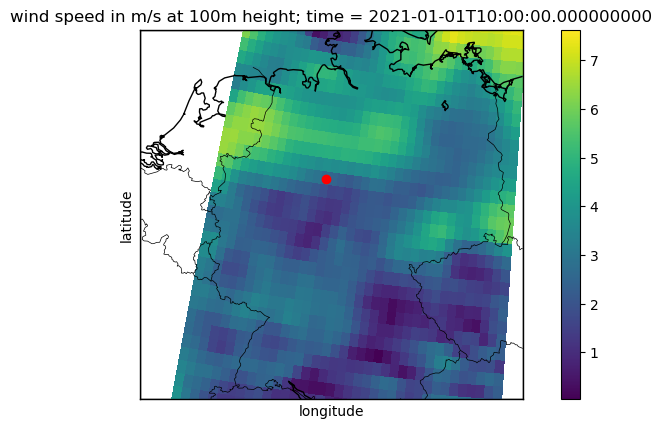

In [38]:
m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

#define two locations
loc1 = 13

x1,y1 = m(lon[loc1,loc1], lat[loc1,loc1])


cs = m.pcolor(xi,yi,np.squeeze(ws100[10,:,:]))

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
cbar = m.colorbar(cs, location='right', pad="10%")
tt = np.array(time[10])
plt.title('wind speed in m/s at 100m height; time = '+str(tt))
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.plot(xi[lon1,lon1], yi[lat1,lat1],'ro')
plt.plot(x1, y1,'ro')
plt.show()



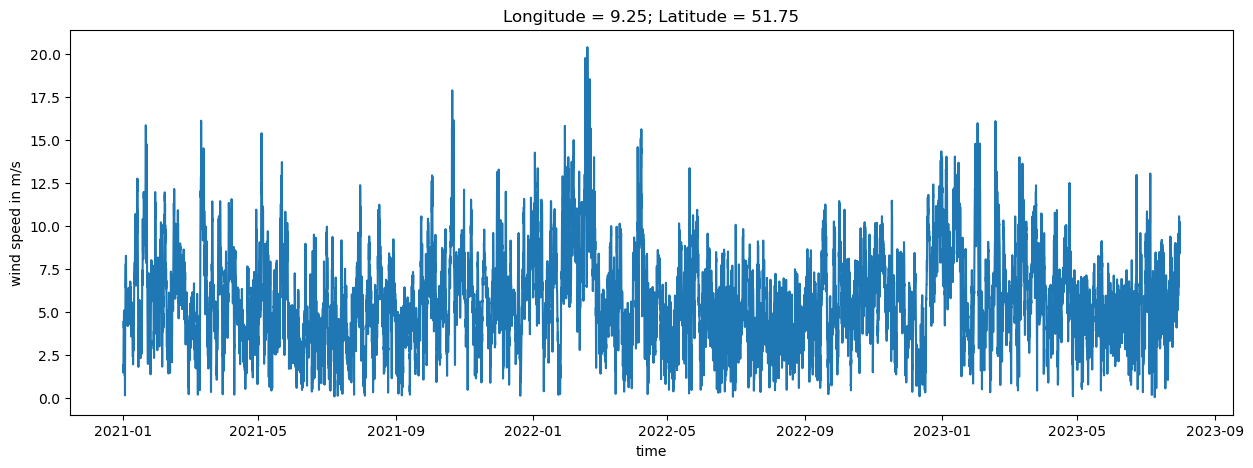

In [39]:
plt.figure(figsize=(15,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()




# Brown et al. 1984

(1.9887928881154042, 0, 2.905815136159106)


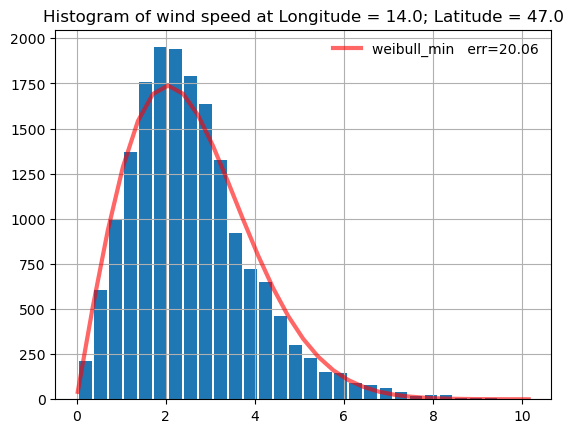

In [43]:
import scipy.stats as s
loc1 = 32
N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))

f, ax = plt.subplots(1, 1)

ax.bar(bins[:-1]+bin_width/2., counts, align='center', width=.85*bin_width)
ax.grid('on')
def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    print(params)
    y = dist.pdf(bins, *params)*total_count*bin_width
    sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return y

colors = ['r-', 'g-', 'r:', 'g:']

for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
    y = fit_pdf(x1, name=name, color=color)

ax.legend(loc='best', frameon=False)
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Histogram of wind speed at '+'Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.show()






In [44]:
# statistical overview over distribution of wind time series
N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))


def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    #y = dist.pdf(bins, *params)*total_count*bin_width
    #sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    #ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return params

colors = ['r-', 'g-', 'r:', 'g:']

#for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
#    for i in range(33):
#        x1 = ws100[0:2*24*365,i,i]
#        params = fit_pdf(x1, name=name, color=color)
#        print(params)




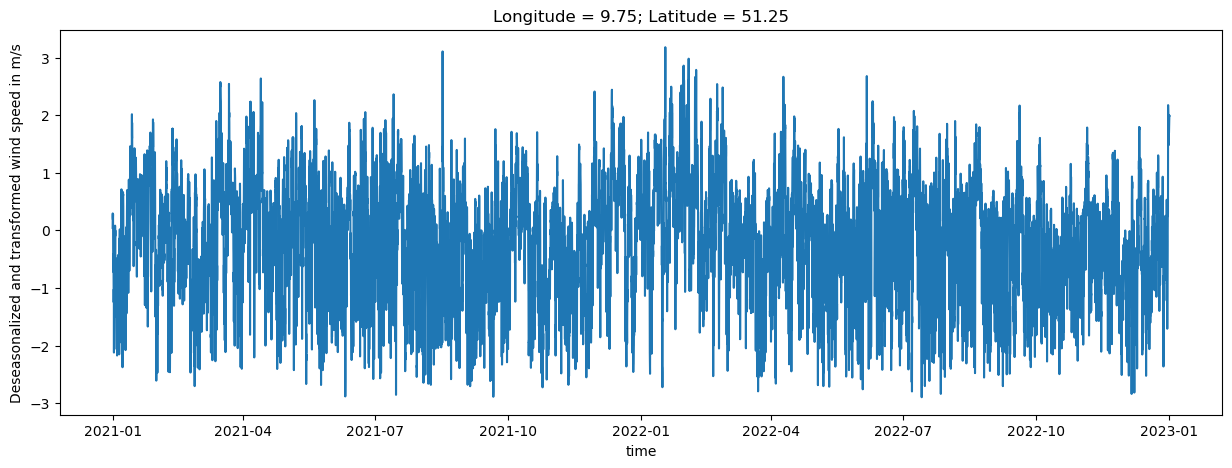

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


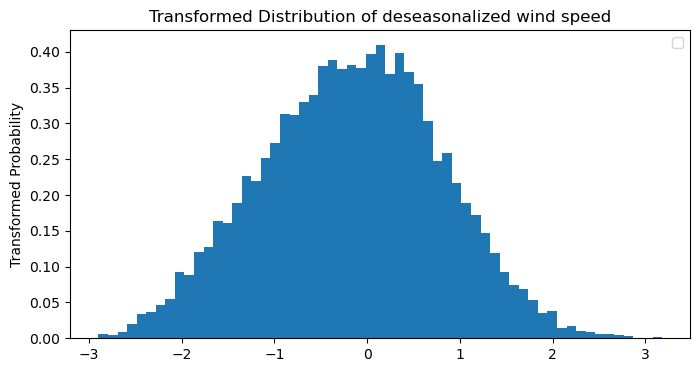

In [45]:
# deseasonalization
mu = []
for i in range(0,24):
    mu.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        mu[i] = mu[i] + x1[j]
        count = count + 1

    mu[i] = mu[i]/count


sigma = []
for i in range(0,24):
    sigma.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        sigma[i] = sigma[i] + (x1[j] - mu[i])**2
        count = count + 1

    sigma[i] = np.sqrt(sigma[i]/count)

for i in range(0,24):
    for j in range(i,len(x1)-24,24):
        x1[j] = (x1[j] - mu[i])/sigma[i]

#plt.figure(figsize=(15,5))
#plt.plot(time[0:2*24*365],x1)
#sel_lon = np.array(lons[15])
#sel_lat = np.array(lats[15])
#plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
#plt.ylabel('Deseasonalized wind speed in m/s')
#plt.xlabel('time')
#plt.show()

#fig, ax = plt.subplots(figsize=(8, 4))
#ax.hist(x1, bins='auto', density=True)
#ax.set_ylabel('Probability')
#ax.set_title('Distribution of deseasonalized wind speed')
#ax.legend();

#box cox transformation (transform data to normal distribution)
from scipy.special import boxcox, inv_boxcox
x_trans = s.yeojohnson(x1,0.5)

xt = x_trans


plt.figure(figsize=(15,5))
plt.plot(time[0:2*24*365],xt)
sel_lon = np.array(lons[15])
sel_lat = np.array(lats[15])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('Deseasonalized and transformed wind speed in m/s')
plt.xlabel('time')
plt.show()


#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
#plot_acf(xt,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
#plot_pacf(xt)

# visual inspection

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(xt, bins='auto', density=True)
ax.set_ylabel('Transformed Probability')
ax.set_title('Transformed Distribution of deseasonalized wind speed')
ax.legend();


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

#prob = s.probplot(x1, dist=s.norm, plot=ax1)
#prob = s.probplot(xt, dist=s.norm, plot=ax2)

#ax1.set_title('Original Data')
#ax1.set_ylabel('Wind Speed')
#ax2.set_title('Transforamed Data, λ = 0.5');
#ax2.set_ylabel('');


72


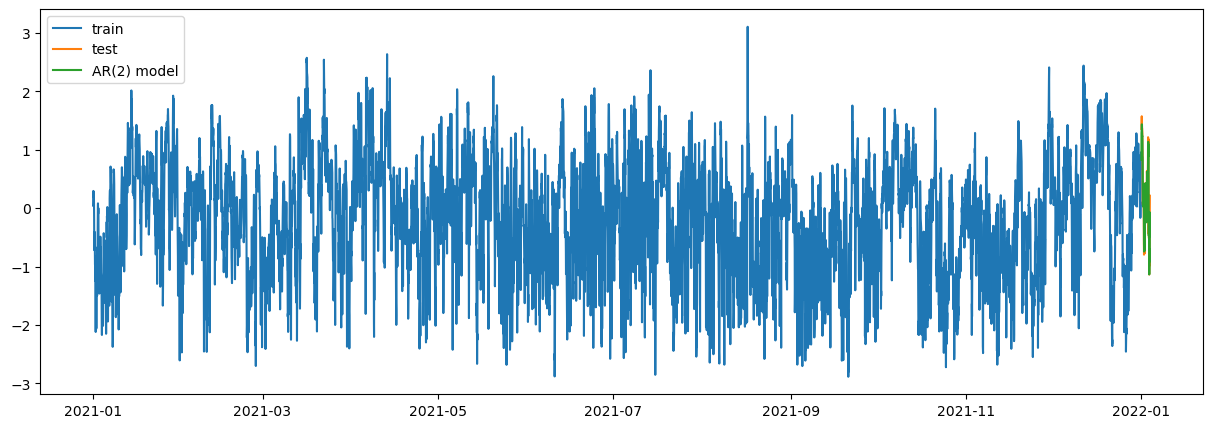

In [54]:
train= x1[:24*365]
test= x1[365*24:2*365*24]

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df, train_len, horizon, window):
    
    total_len = train_len + horizon
    end_idx = train_len
    
    pred_AR = []
    
    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(2,0,0))
        res = model.fit(disp=False) 
        predictions = res.get_prediction(0, i + window -1 )
        oos_pred = predictions.predicted_mean[-window:]
        pred_AR.extend(oos_pred)
            
    return pred_AR

train_len = 24*365
horizon = 24*3
window = 1
pred_AR = rolling_forecast(xt, train_len, horizon, window)

print(len(pred_AR))

plt.figure(figsize=(15,5))
#plt.plot(time[0:2*24*365],xt,label='data')
plt.plot(time[0:train_len],xt[0:train_len],label='train')
plt.plot(time[train_len:train_len+horizon],xt[train_len:train_len+horizon],label='test')
plt.plot(time[train_len:train_len+horizon],pred_AR,label='AR(2) model')
plt.legend()



# OU-Process


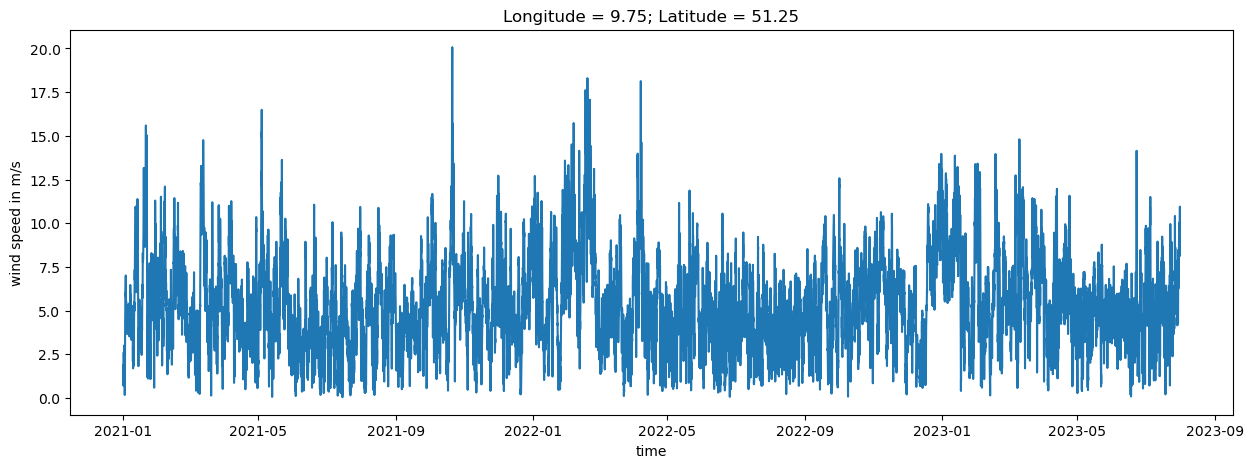

In [10]:
plt.figure(figsize=(15,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()

[ 2.18115606  0.1047904   1.00744397 -0.10252313  0.98673703]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


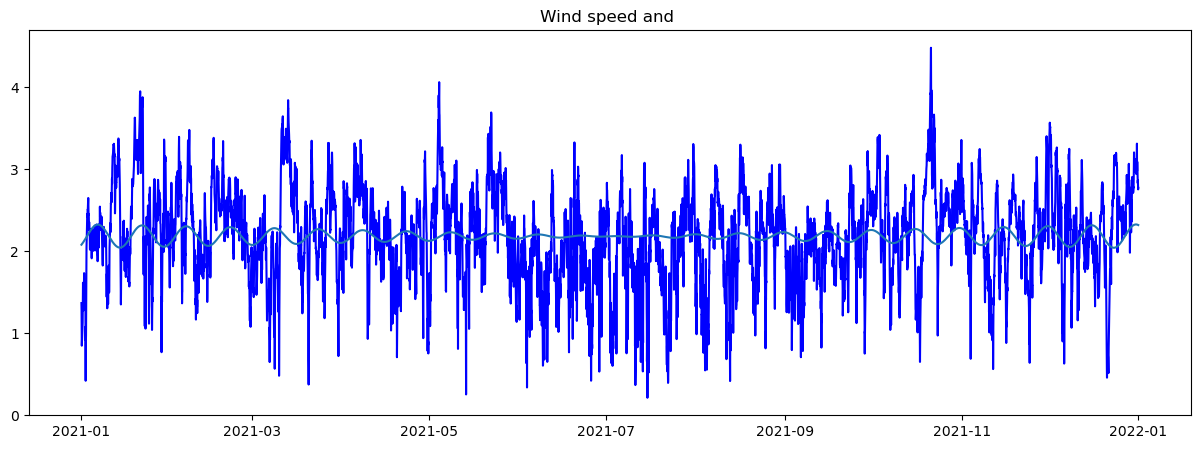

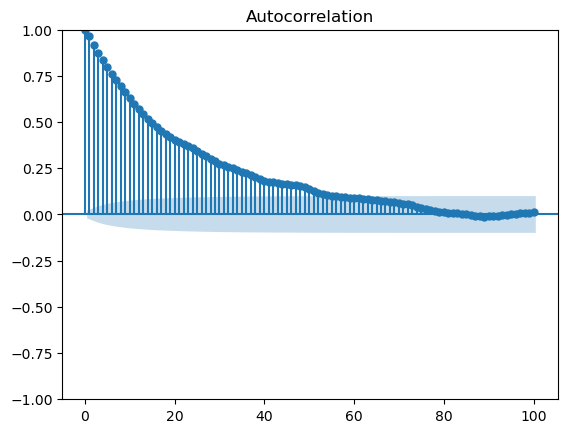

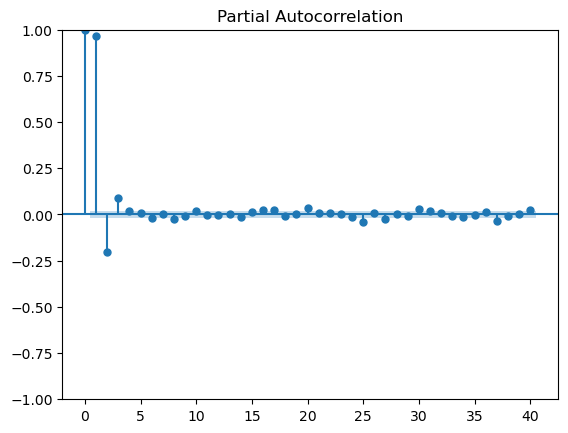

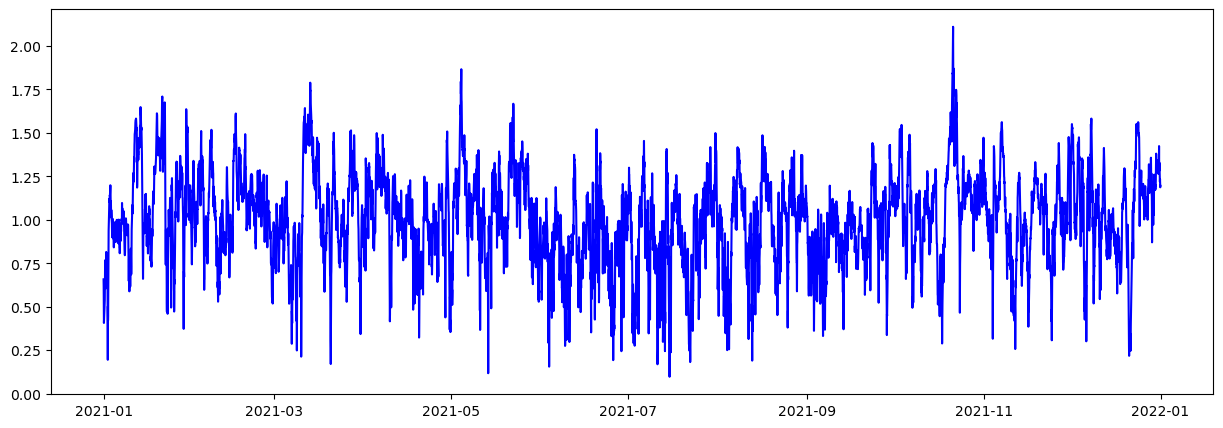

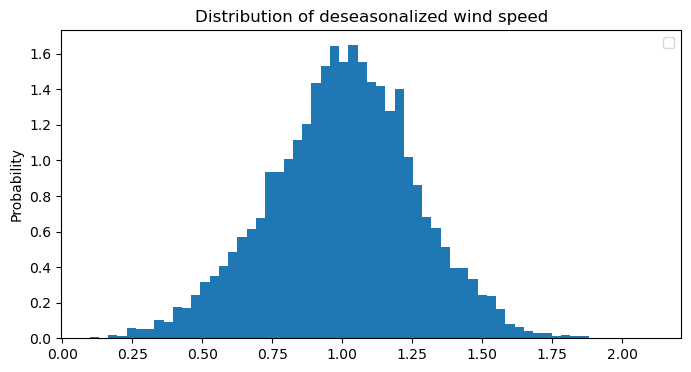

In [11]:
# deseasonalize by fitting 
# a_1 + a_2 sin(2*pi*t/365) + a_3 cos(2*pi*t/365)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
xdata = np.linspace(0, 1*365*24,1*365*24)
ydata = np.sqrt(ws100[0:1*365*24,loc1,loc1])


def func(x, a, b, c,d,e):
    return a + b* np.sin(c*2.*np.pi * x/365.) + d* np.cos(e*2.*np.pi * x/365.)

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydata, 'b-', label='data')
plt.plot(time[0:1*365*24], func(xdata, *popt))
plt.title('Wind speed and ')



ydes = ydata/func(xdata, *popt)


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
plot_acf(ydes,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
plot_pacf(ydes)



plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydes, 'b-', label='data')


fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ydes, bins='auto', density=True)
ax.set_ylabel('Probability')
ax.set_title('Distribution of deseasonalized wind speed')
ax.legend();


[ 4.43064742 -0.0620011   0.99864292  0.27766612  0.99428217]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


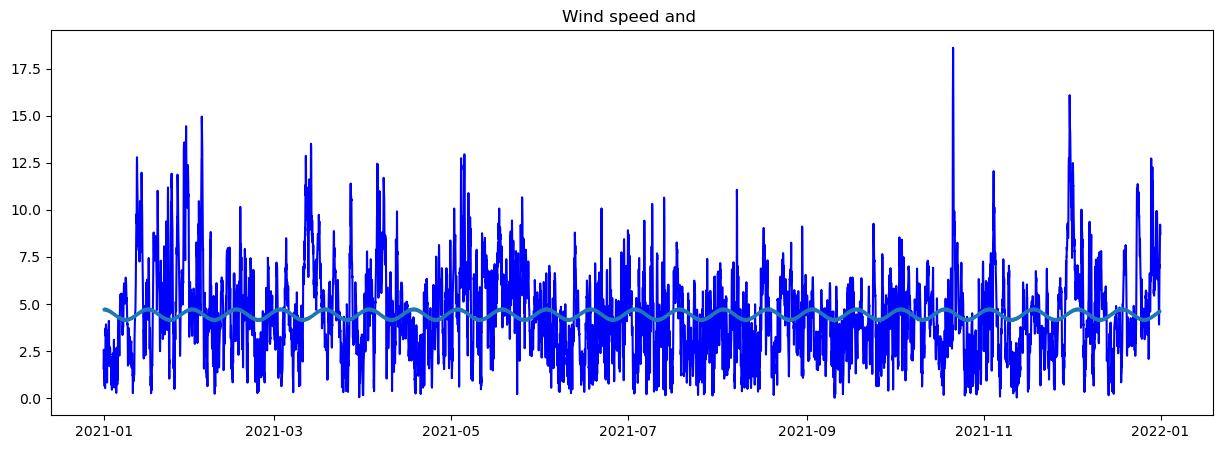

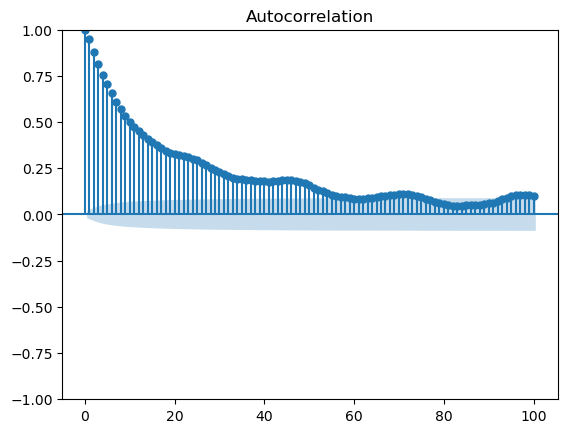

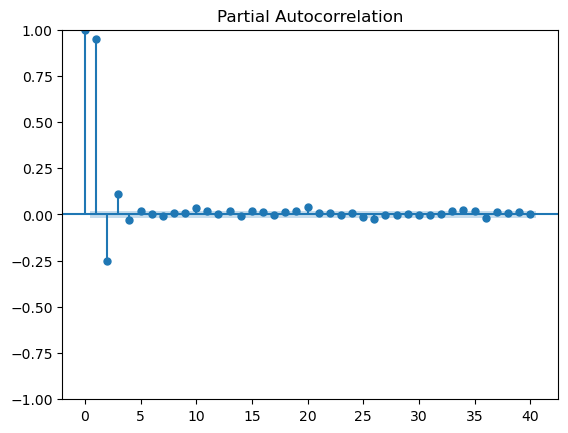

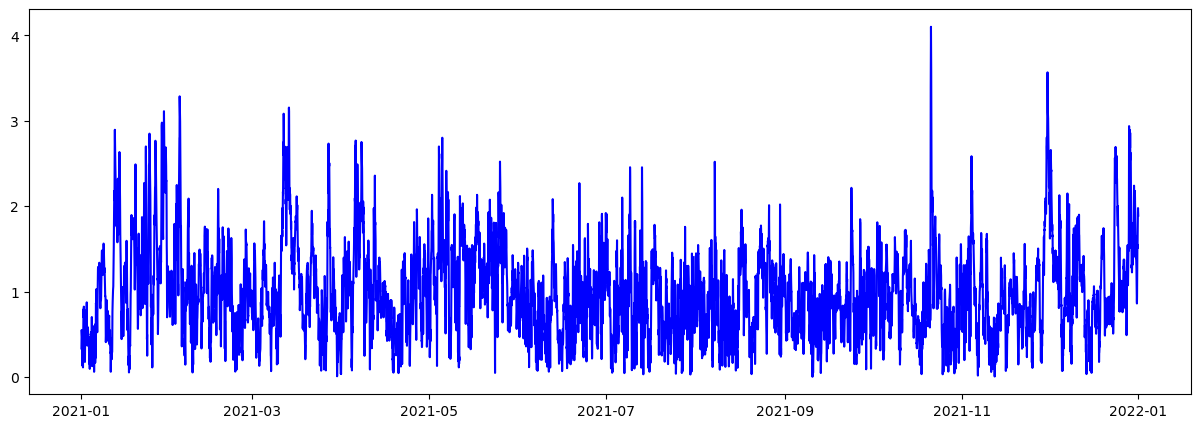

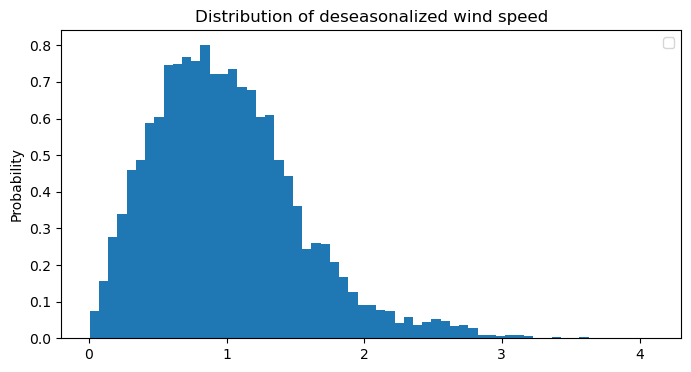

In [12]:
# deseasonalize by fitting 
# a_1 + a_2 sin(2*pi*t/365) + a_3 cos(2*pi*t/365)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
xdata = np.linspace(0, 1*365*24,1*365*24)
ydata = ws100[0:1*365*24,loc2,loc2]



def func(x, a, b, c,d,e):
    return a + b* np.sin(c*2.*np.pi * x/12) + d* np.cos(e*2.*np.pi * x/365)

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydata, 'b-', label='data')
plt.plot(time[0:1*365*24], func(xdata, *popt))
plt.title('Wind speed and ')



ydes = ydata/func(xdata, *popt)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
plot_acf(ydes,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
plot_pacf(ydes)



plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydes, 'b-', label='data')


fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ydes, bins='auto', density=True)
ax.set_ylabel('Probability')
ax.set_title('Distribution of deseasonalized wind speed')
ax.legend();

# Concept
